In [1]:
%matplotlib inline

import math
import datetime
import os

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
cuda = True
debug = False
N = 4
one_hot_size = 32
fig_counter = 0

base_dir = '../../../../../experiments1-logs/thingml-bytes-logs/nodejs/'

In [3]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

## Encoding/decoding ThingML messages into 1-D tensors

The encoding of training, validation and test data is based by parsing lines starting with `!` and `@` in the logs.

### 1-hot encoding

ThingML messages are encoded into 1D tensors, using a simple 1-hot encoding:
- first, we encode the message type. Here, indices 0..13 are used to encode messages `clear`..`updateIA`. In principle, there will only be a single `1.0` value in the range 0..13, indicating that a message is either a `clear` message or (XOR) a `setColor` message, etc. However, the prediction will likely produce result like `clear:0.87`, `setColor:0.14`, etc. We decode the message type by taking the highest score.
- second, we encode the parameters of the message e.g. indices 14..16 are used to encode `r`, `g` and `b`. Note that different messages can have the same parameters (or a common subset), and in this case, indices for parameters will be reused. For example, indices 14..16 are used by `setColor` and `setBGColor`. A parameter is predicted present if it scores `>= 0.5`. 

### Example

A message `setColor(r=107, b=94, b=174)` send by the `BreakoutGame` thing is serialized as `[3,107,94,174]` on the network. 

In the log files, this is represented by `!3,107,94,174,` followed by `@BreakoutGameNodeJS@setColor,r,g,b,`. See `def logToData(filename)`

The same message is 1-hot encoded as `[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 0, ..., 0]`. It is decoded as `[setColor, r, g, b]`.

Assume a prediction producing the following 1D tensor:

`predict = [0.22, 0.87, 0.17, 0.32, 0.12, 0.33, 0.22, 0.13, 0.17, 0.16, 0.32, 0.33, 0.37, 0.18, 0.67, 0.44, 0.55, <0.5, <0.5, ..., <0.5]`

This will be decoded as `[setColor, r, b]`. Indeed:
- predict[1] > predict[*n*] for *n* in 0..13, and predict[1] encodes for `setColor`
- predict[14] = 0.67 >= 0.5, and predict[14] encodes for parameter `r`
- predict[15] = 0.44 < 0.5,  and predict[15] encodes for parameter `g`. Parameter `g` is thus not deemed to be present.
- predict[16] = 0.55 >= 0.5, and predict[16] encodes for parameter `b`

In [14]:
# 1-hot encoding of the ThingML messages between controller/AI and game logic
def encode(msg):
    encoded = [0]*one_hot_size
    valid = False
    for x in msg:
        # Encode message
        if x.startswith('clear'):
            encoded[0] = 1
            valid = True
        elif x.startswith('setColor'):
            encoded[1] = 1
            valid = True
        elif x.startswith('setBGColor'):
            encoded[2] = 1
            valid = True
        elif x.startswith('drawRect'):
            encoded[3] = 1
            valid = True
        elif x.startswith('fillRect'):
            encoded[4] = 1
            valid = True
        elif x.startswith('drawInteger'):
            encoded[5] = 1
            valid = True
        elif x.startswith('drawThingML'):
            encoded[6] = 1
            valid = True
        elif x.startswith('create'):
            encoded[7] = 1
            valid = True
        elif x.startswith('destroy'):
            encoded[8] = 1
            valid = True
        elif x.startswith('update'):
            encoded[9] = 1
            valid = True
        elif x.startswith('displayReady'):
            encoded[10] = 1
            valid = True
        elif x.startswith('velocity'):
            encoded[11] = 1
            valid = True
        elif x.startswith('position'):
            encoded[12] = 1
            valid = True
        elif x.startswith('updateIA'):
            encoded[13] = 1
            valid = True
        else: # Encode params                       
            if x == 'r':
                encoded[14] = 1
            elif x == 'g':
                encoded[15] = 1
            elif x == 'b':
                encoded[16] = 1  
            elif x == 'x':
                encoded[17] = 1   
            elif x == 'y':
                encoded[18] = 1
            elif x == 'width':
                encoded[19] = 1
            elif x == 'height':
                encoded[20] = 1  
            elif x == 'v':
                encoded[21] = 1   
            elif x == 'digits':
                encoded[22] = 1                
            elif x == 'scale':
                encoded[23] = 1  
            elif x == 'xsize':
                encoded[24] = 1   
            elif x == 'ysize':
                encoded[25] = 1   
            elif x == 'dx':
                encoded[26] = 1                
            elif x == 'dy':
                encoded[27] = 1  
            elif x == 'padx':
                encoded[28] = 1   
            elif x == 'pady':
                encoded[29] = 1                   
            elif x == 'ballx':
                encoded[30] = 1   
            elif x == 'bally':
                encoded[31] = 1
    if valid:
        #print(encoded)
        return encoded
    else:
        return None


def decode(encoded):
    message = []
    
    # decode message
    max_id = -1
    max_v = 0
    for i in range(0, 13):
        if encoded[i] > max_v:
            max_v = encoded[i]
            max_id = i
    if max_id == 0:
        message.append('clear')
    elif max_id == 1:
        message.append('setColor')
    elif max_id == 2:
        message.append('setBGColor')
    elif max_id == 3:
        message.append('drawRect')
    elif max_id == 4:
        message.append('fillRect')
    elif max_id == 5:
        message.append('drawInteger')
    elif max_id == 6:
        message.append('drawThingML')
    elif max_id == 7:
        message.append('create')
    elif max_id == 8:
        message.append('destroy')
    elif max_id == 9:
        message.append('update')
    elif max_id == 10:
        message.append('displayReady')
    elif max_id == 11:
        message.append('velocity')
    elif max_id == 12:
        message.append('position')
    elif max_id == 13:
        message.append('updateIA')
    else:
        message.append('???')
            
    # decode params
    if encoded[14] >= 0.5:
        message.append('r')
    if encoded[15] >= 0.5:
        message.append('g')
    if encoded[16] >= 0.5:
        message.append('b')
    if encoded[17] >= 0.5:
        message.append('x') 
    if encoded[18] >= 0.5:
        message.append('y') 
    if encoded[19] >= 0.5:
        message.append('width') 
    if encoded[20] >= 0.5:
        message.append('height') 
    if encoded[21] >= 0.5:
        message.append('v')   
    if encoded[22] >= 0.5:
        message.append('digits')                 
    if encoded[23] >= 0.5:
        message.append('scale')                 
    if encoded[24] >= 0.5:
        message.append('xsize')                 
    if encoded[25] >= 0.5:
        message.append('ysize')                 
    if encoded[26] >= 0.5:
        message.append('dx')                 
    if encoded[27] >= 0.5:
        message.append('dy')                 
    if encoded[28] >= 0.5:
        message.append('padx')   
    if encoded[29] >= 0.5:
        message.append('pady')              
    if encoded[30] >= 0.5:
        message.append('ballx')   
    if encoded[31] >= 0.5:
        message.append('bally')   
                        
    return message
        

def logToData(filename):
    file = open(filename)
    score = -1
    line = file.readline()
    while line:                      
        if line.startswith('ts:'):
            score = int(line[1:].strip().split(',')[2].split(':')[1:][0])            
            line = file.readline()
        elif not line.startswith('@'):
            line = file.readline()
        while line and line.startswith('@'):
            raw_bytes_float = []
            encoded = encode(line.split('@')[2].split(','))
            line = file.readline()      
            while line and line.startswith('!'):                
                raw_bytes = list(line[1:].strip().split(',')[:-1])                    
                for b in raw_bytes:
                    raw_bytes_float.append(int(b)/255)
                line = file.readline()      
            if encoded != None:
                yield raw_bytes_float, encoded                    
    if score != 349:
        print('In ' + filename + ' : final score should be 349. Was ' + str(score))

In [15]:
logs = list(logToData('../../resources/experiments1/log/example.log'))
logs

[([0.0392156862745098, 0.043137254901960784, 0.47058823529411764, 0.0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]),
 ([0.1843137254901961,
   0.0,
   0.0,
   0.0,
   0.1803921568627451,
   0.0,
   0.3607843137254902,
   0.0,
   0.050980392156862744,
   0.0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]),
 ([0.15294117647058825,
   0.47058823529411764,
   0.0,
   0.5764705882352941,
   0.0,
   0.1568627450980392,
   0.0,
   0.14901960784313725,
   0.20784313725490197,
   0.0],
  [0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]),
 ([0.023529411764705882,
   

In [5]:
def loadAllData(base, N):
    maxbytelen = 0
    logs = []
    for i in range(0,N):
        log = list(logToData(base+str(i)+'.log'))
        logs.append(log)
        for msg in log:
            length = len(msg[0])
            maxbytelen = max(maxbytelen, length)
    X = []
    Y = []
    for log in logs:
        x = np.zeros((len(log),maxbytelen))
        #x = np.zeros((len(log),one_hot_size))
        y = np.zeros((len(log),one_hot_size))
        for i, msg in enumerate(log):
            x[i,0:len(msg[0])] = msg[0]
            y[i,:] = msg[1]
        X.append(x)
        Y.append(y)
    return X, Y, maxbytelen

In [6]:
base_X, base_Y, base_maxbytelen = loadAllData(base_dir+'base/nodejs', N)
static_X, static_Y, static_maxbytelen = loadAllData(base_dir+'static/nodejs', N)
runtime_X, runtime_Y, runtime_maxbytelen = loadAllData(base_dir+'dynamic/nodejs', N)

NMSGS = len(base_X[0]) # Number of original messages
NMSGS_static = len(static_X[0])
NMSGS_runtime = len(runtime_X[0])

def number_msgs(mode):
    if mode == 'base':
        return NMSGS
    elif mode == 'static':
        return NMSGS_static
    elif mode == 'runtime':
        return NMSGS_runtime
    return -1

In [7]:
def split(data, train_ratio = 0.50):
    train = []
    test = []
    for log in data:
        length = log.shape[0]
        train_size = int(length * train_ratio)
        train.append(log[0:train_size,:])
        test.append(log[train_size:,:])
    return train, test

base_X_train, base_X_test = split(base_X)
base_Y_train, base_Y_test = split(base_Y)

static_X_train, static_X_test = split(static_X)
static_Y_train, static_Y_test = split(static_Y)

runtime_X_train, runtime_X_test = split(runtime_X)
runtime_Y_train, runtime_Y_test = split(runtime_Y)

In [8]:
number_of_msgs = 8 

def series_to_supervised(all_data, maxbytelen):
    results = []
    for j in range(0,N):
        result = []
        data = all_data[j].flatten()
        for i in range(0,int(len(data)/(number_of_msgs*maxbytelen))):
            time_window = data[i*maxbytelen:number_of_msgs*maxbytelen+i*maxbytelen]
            result.append(time_window)
        results.append(result)
    np_results = np.array(results)
    np_results = np.reshape(np_results, (np_results.shape[0], np_results.shape[1], number_of_msgs, int(np_results.shape[2]/number_of_msgs)))
    return np_results

base_X_train_supervised = series_to_supervised(base_X_train, base_maxbytelen)
static_X_train_supervised = series_to_supervised(static_X_train, static_maxbytelen)
runtime_X_train_supervised = series_to_supervised(runtime_X_train, runtime_maxbytelen)

base_Y_train_supervised = series_to_supervised(base_Y_train, one_hot_size)
static_Y_train_supervised = series_to_supervised(static_Y_train, one_hot_size)
runtime_Y_train_supervised = series_to_supervised(runtime_Y_train, one_hot_size)

base_X_test_supervised = series_to_supervised(base_X_test, base_maxbytelen)
static_X_test_supervised = series_to_supervised(static_X_test, static_maxbytelen)
runtime_X_test_supervised = series_to_supervised(runtime_X_test, runtime_maxbytelen)

base_Y_test_supervised = series_to_supervised(base_Y_test, one_hot_size)
static_Y_test_supervised = series_to_supervised(static_Y_test, one_hot_size)
runtime_Y_test_supervised = series_to_supervised(runtime_Y_test, one_hot_size)

if debug:
    print(base_X_train_supervised.shape, ' ', base_Y_train_supervised.shape)
    print(static_X_train_supervised.shape, ' ', static_Y_train_supervised.shape)
    print(runtime_X_train_supervised.shape, ' ', runtime_Y_train_supervised.shape)

    print(base_X_test_supervised.shape, ' ', base_Y_test_supervised.shape)
    print(static_X_test_supervised.shape, ' ', static_Y_test_supervised.shape)
    print(runtime_X_test_supervised.shape, ' ', runtime_Y_test_supervised.shape)

In [9]:
def keras_model(x, y):    
    model = keras.Sequential()
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(50, activation='relu', input_dim=x), input_shape=(number_of_msgs,x,)))
    if cuda:
        model.add(keras.layers.CuDNNLSTM(30, return_sequences=True))
    else:
        model.add(keras.layers.LSTM(30, return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(20, activation='relu')))
    model.add(keras.layers.Dense(y, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])    
    return model

def train_and_save(model, train_X, train_Y, mode, xp, save=False):        
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=4, verbose=1, mode='min')
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1, mode='min')
    earlystop_acc = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.001, patience=4, verbose=1, mode='max')
    earlystop_val_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.001, patience=4, verbose=1, mode='max')
    
    tensorboard_log = keras.callbacks.TensorBoard(log_dir=base_dir+'/tensorboard/'+mode+'/'+str(xp))
    
    callbacks_list = [tensorboard_log, earlystop_loss, earlystop_val_loss, earlystop_acc, earlystop_val_acc]  
        
    model.fit(train_X, train_Y, batch_size=1, epochs=15, validation_split=0.2, verbose=1 if debug else 0, callbacks=callbacks_list)

    if save:
        model.save_weights(base_dir + mode + str(xp) + '_class_lstm.h5')

    return model

In [10]:
def predict(model, test_X, test_Y, mode):
    predictions = model.predict(test_X)    
    errors = 0
    for i in range(0, predictions.shape[0]):
        for j in range(0, predictions.shape[2], one_hot_size):
            predicted = np.array(encode(decode(predictions[i][0][j:j+one_hot_size]))).astype(int)
            truth = test_Y[i][0][j:j+one_hot_size].astype(int)            
            hasErr = False
            # errors += 0.5 if message is not properly classified
            if np.sum(np.abs(predicted[:14] - truth[:14])) > 0:
                errors = errors + 0.5
                hasErr = True
            # errors += 0.5 if at least a parameter is not properly classified
            if np.sum(np.abs(predicted[14:] - truth[14:])) > 0:
                errors = errors + 0.5
                hasErr = True
            if debug and hasErr > 0:
                print('Predicting ', decode(predicted), '. Truth is ', decode(truth))    
    error_ratio = errors/number_msgs(mode)
    return error_ratio

In all experiments, the logs are parsed, 1-hot encoded and split as follows:
- 40% in the training set
- 10% in the validation set
- 50% in the test set

All experiments will use the same type of model, which is basically articulated around **a core LSTM (Long Short-Term Memory) layer**. The choice of LSTM is motivated by the strong temporal aspect in the data: the fact that a message `M` is emitted at instant `t` is strongly related to the fact that a message `M'` was emitted at `t-1`, and that a message `M''` was emitted at `t-2`, etc. Since the behavior of the state machines implementing the test protocols is, to a large extent repetitive, the context/history is as relevant as the current data itself to be able to learn and make good predictions. 

In all experiments, the training will be done for at most 20 Epochs and early stops are defined to reduce the risk of overfitting. The ultimate goal of those experiments is indeed to determine if/how the knowledge acquired for a specific protocol can be transfered to another (diversified) protocol.

## Experiment 1

This experiment aims at determining how "*learnable*" is each protocol. It goes through all protocols: 100 non-diversified, 100 statically-diversified and 100 dynamically-diversified. 

For each protocol, an LSTM model is trained (using the 40% + 10% data sets) and prediction are made for the remaining 50% data. In other words, this experiment gives an indication about if/how each individual protocol can be learned.

The weights for the trained models are saved and will be reused later to determine how the knowledge gained on individual protocols can be transfered to other protocols.

In [11]:
def xp(train_X, train_Y, test_X, test_Y, mode):
    print('xp ', mode)
    errs = []
    train_t = []
    predict_t = []
    for i in range(0, N): 
        print('  #', i)
        print('----')
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], mode, i, save=True)
        train_stop = predict_start = datetime.datetime.now()
        if debug:
            model.summary()        
        error_ratio = predict(model, test_X[i], test_Y[i], mode)
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        if debug:
            print(round(error_ratio*100,2), '% error')
            print('training duration = ', train_duration)
            print('prediction duration = ', predict_duration)
        errs.append(error_ratio)
        train_t.append(train_duration)
        predict_t.append(predict_duration)        
    return errs, train_t, predict_t

In [12]:
base_err, base_tt, base_pt = xp(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_err, static_tt, static_pt = xp(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_err, runtime_tt, runtime_pt = xp(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

xp  base
  # 0
----
Epoch 00008: early stopping
  # 1
----
Epoch 00007: early stopping
  # 2
----
Epoch 00008: early stopping
  # 3
----
Epoch 00009: early stopping
xp  static
  # 0
----
Epoch 00015: early stopping
  # 1
----
Epoch 00009: early stopping
  # 2
----
  # 3
----
Epoch 00015: early stopping
xp  runtime
  # 0
----
Epoch 00014: early stopping
  # 1
----
  # 2
----
Epoch 00011: early stopping
  # 3
----
Epoch 00015: early stopping


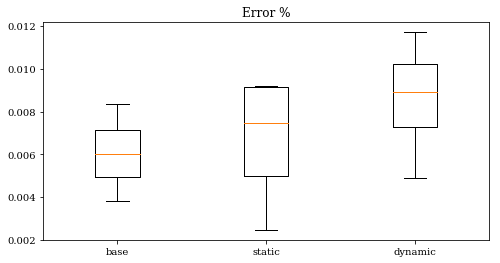

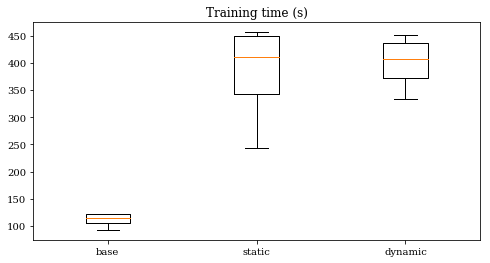

In [13]:
all_err = []
all_err.append(base_err)
all_err.append(static_err)
all_err.append(runtime_err)

fig = plt.figure(fig_counter, figsize=(8,4))        
plt.boxplot(all_err, 0, '')
plt.xticks(range(1, 4), ('base', 'static', 'dynamic'))
plt.title('Error %')
plt.show()  
fig_counter = fig_counter + 1


all_tt = []
all_tt.append([t.total_seconds() for t in base_tt])
all_tt.append([t.total_seconds() for t in static_tt])
all_tt.append([t.total_seconds() for t in runtime_tt])

fig = plt.figure(fig_counter, figsize=(8,4))        
plt.boxplot(all_tt, 0, '')
plt.xticks(range(1, 4), ('base', 'static', 'dynamic'))
plt.title('Training time (s)')
plt.show()  
fig_counter = fig_counter + 1

T = np.sum(np.array([t.total_seconds() for t in base_tt]))/N # Average learning time for base protocol

## Experiment 2



In [14]:
def xp2(train_X, train_Y, test_X, test_Y, mode):
    errs = []
    train_t = []
    predict_t = []
    for i in range(0,N):
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        model.load_weights(base_dir + mode + str(i) + '_class_lstm.h5')
        for j in range(0,N):
            print('using model ', str(i), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j], mode)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(round(error_ratio*100,2), '% error')
            print('prediction duration = ', predict_duration)
            errs.append(error_ratio)
            predict_t.append(predict_duration)            
    return errs, train_t, predict_t

base_err2, _, base_pt2  = xp2(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_err2, _, static_pt2 = xp2(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_err2, _, runtime_pt2 = xp2(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

using model  0  on data coming from  0
-------------------------
0.84 % error
prediction duration =  0:00:00.648975
using model  0  on data coming from  1
-------------------------
0.84 % error
prediction duration =  0:00:00.135968
using model  0  on data coming from  2
-------------------------
0.84 % error
prediction duration =  0:00:00.163999
using model  0  on data coming from  3
-------------------------
0.84 % error
prediction duration =  0:00:00.132032
using model  1  on data coming from  0
-------------------------
0.53 % error
prediction duration =  0:00:00.631441
using model  1  on data coming from  1
-------------------------
0.53 % error
prediction duration =  0:00:00.155972
using model  1  on data coming from  2
-------------------------
0.53 % error
prediction duration =  0:00:00.155999
using model  1  on data coming from  3
-------------------------
0.53 % error
prediction duration =  0:00:00.128027
using model  2  on data coming from  0
-------------------------
0.38 % 

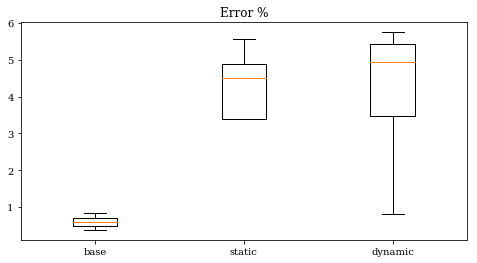

In [15]:
all_err2 = []
all_err2.append(np.array(base_err2)*100)
all_err2.append(np.array(static_err2)*100)
all_err2.append(np.array(runtime_err2)*100)

fig = plt.figure(fig_counter, figsize=(8,4))        
plt.boxplot(all_err2, 0, '')
plt.xticks(range(1, 4), ('base', 'static', 'dynamic'))
plt.title('Error %')
plt.show()  
fig_counter = fig_counter + 1

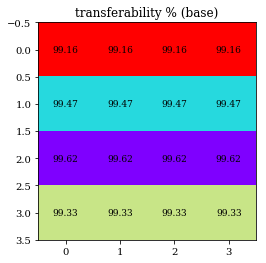

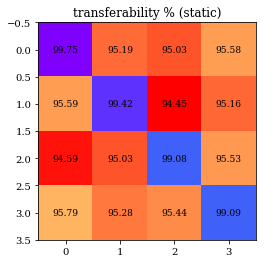

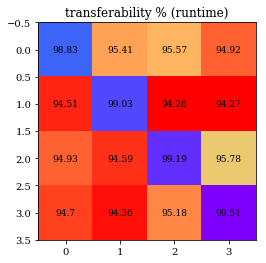

In [16]:
def get_error_matrices(errors):
    error_matrix = np.empty([N,N], dtype=float)
    for i in range(0,N):
        for j in range(0,N):
            error_matrix[i][j] = errors[N*i+j]
    return error_matrix

def plot_matrices(error_matrix, mode):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(N, N))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, round(((1-error_matrix[i, j]))*100, 2), ha="center", va="center", color="black", fontsize = 9)

    ax.set_title("transferability % (" + mode + ")", fontsize = 12)
    #fig.tight_layout()
    plt.show()
#     plt.savefig(mode+'_error_generalization_class_xp2.png', dpi=300)
    
    
base_error_matrix = get_error_matrices(base_err2)
static_error_matrix = get_error_matrices(static_err2)
runtime_error_matrix = get_error_matrices(runtime_err2)    
    
plot_matrices(base_error_matrix, 'base')
plot_matrices(static_error_matrix, 'static')    
plot_matrices(runtime_error_matrix, 'runtime')  

In [18]:
group_by = 2

def xp3(train_X, train_Y, test_X, test_Y, mode):
    if group_by > N: 
        return
    results = []
    for i in range(0,N,group_by):    
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        for j in range(i,min(i+group_by, N)):
            model = train_and_save(model, train_X[j], train_Y[j], mode, 1000*i+j, save=False)
            
# randomize = np.arange(len(x))
# np.random.shuffle(randomize)
# x = x[randomize]
# y = y[randomize]
            
        if debug:
            model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start            
        for j in range(0,N):
            print('using model ', str(i), '-', str(i+group_by-1), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j], mode)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_3 = xp3(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_3 = xp3(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_3 = xp3(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')      

Epoch 00007: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
using model  0 - 1  on data coming from  0
-------------------------
0.009821687445636416 % error
prediction duration =  0:00:00.888109
using model  0 - 1  on data coming from  1
-------------------------
0.009821687445636416 % error
prediction duration =  0:00:00.156262
using model  0 - 1  on data coming from  2
-------------------------
0.009821687445636416 % error
prediction duration =  0:00:00.134859
using model  0 - 1  on data coming from  3
-------------------------
0.009821687445636416 % error
prediction duration =  0:00:00.143167
Epoch 00007: early stopping
Epoch 00005: early stopping
using model  2 - 3  on data coming from  0
-------------------------
0.005363873586546825 % error
prediction duration =  0:00:00.939668
using model  2 - 3  on data coming from  1
-------------------------
0.005363873586546825 % error
prediction duration =  0:00:00.156439
using model  2 -

KeyboardInterrupt: 